In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency
import numpy as np

In [2]:
patients_df = pd.read_csv("cleaned_PATIENTS.csv")
patients_df

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
46515,31840,44089,M,2026-05-25,NaN,NaN,NaN,0
46516,31841,44115,F,2124-07-27,NaN,NaN,NaN,0
46517,31842,44123,F,2049-11-26,2135-01-12,2135-01-12 00:00:00,NaN,1
46518,31843,44126,F,2076-07-25,NaN,NaN,NaN,0


In [3]:
admissions_df = pd.read_csv("cleaned_ADMISSIONS.csv")
admissions_df

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_LOCATION,DISCHARGE_LOCATION,EDREGTIME,EDOUTTIME,...,ETHNICITY_PATIENT DECLINED TO ANSWER,ETHNICITY_PORTUGUESE,ETHNICITY_SOUTH AMERICAN,ETHNICITY_UNABLE TO OBTAIN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_WHITE,ETHNICITY_WHITE - BRAZILIAN,ETHNICITY_WHITE - EASTERN EUROPEAN,ETHNICITY_WHITE - OTHER EUROPEAN,ETHNICITY_WHITE - RUSSIAN
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,2196-04-09 10:06:00,2196-04-09 13:24:00,...,False,False,False,False,False,True,False,False,False,False
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,TRANSFER FROM HOSP/EXTRAM,HOME,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY ROOM ADMIT,HOME,2160-11-02 01:01:00,2160-11-02 04:27:00,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,CLINIC REFERRAL/PREMATURE,HOME,2131-03-30 19:44:00,2131-03-30 22:41:00,...,False,False,False,False,False,True,False,False,False,False
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,CLINIC REFERRAL/PREMATURE,DEAD/EXPIRED,2151-03-05 17:23:00,2151-03-05 21:06:00,...,False,False,False,False,False,True,False,False,False,False
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,NaN,NaN,...,False,False,False,False,False,True,False,False,False,False
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,EMERGENCY ROOM ADMIT,SNF,2128-11-10 23:48:00,2128-11-11 03:16:00,...,False,False,False,False,False,True,False,False,False,False


In [4]:
icustays_df = pd.read_csv("cleaned_ICUSTAYS.csv")
icustays_df

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.248993
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.278796
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.893854
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.059977
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.620243
...,...,...,...,...,...,...,...,...,...,...,...,...
61517,59806,94944,143774,201233,metavision,CSRU,CSRU,15,15,2104-04-15 10:18:16,2104-04-17 14:51:00,2.189398
61518,59807,94950,123750,283653,metavision,CCU,CCU,7,7,2155-12-08 05:33:16,2155-12-10 17:24:58,2.494236
61519,59808,94953,196881,241585,metavision,SICU,SICU,57,57,2160-03-03 16:09:11,2160-03-04 14:22:33,0.925949
61520,59809,94954,118475,202802,metavision,CSRU,CSRU,15,15,2183-03-25 09:53:10,2183-03-27 17:55:03,2.334641


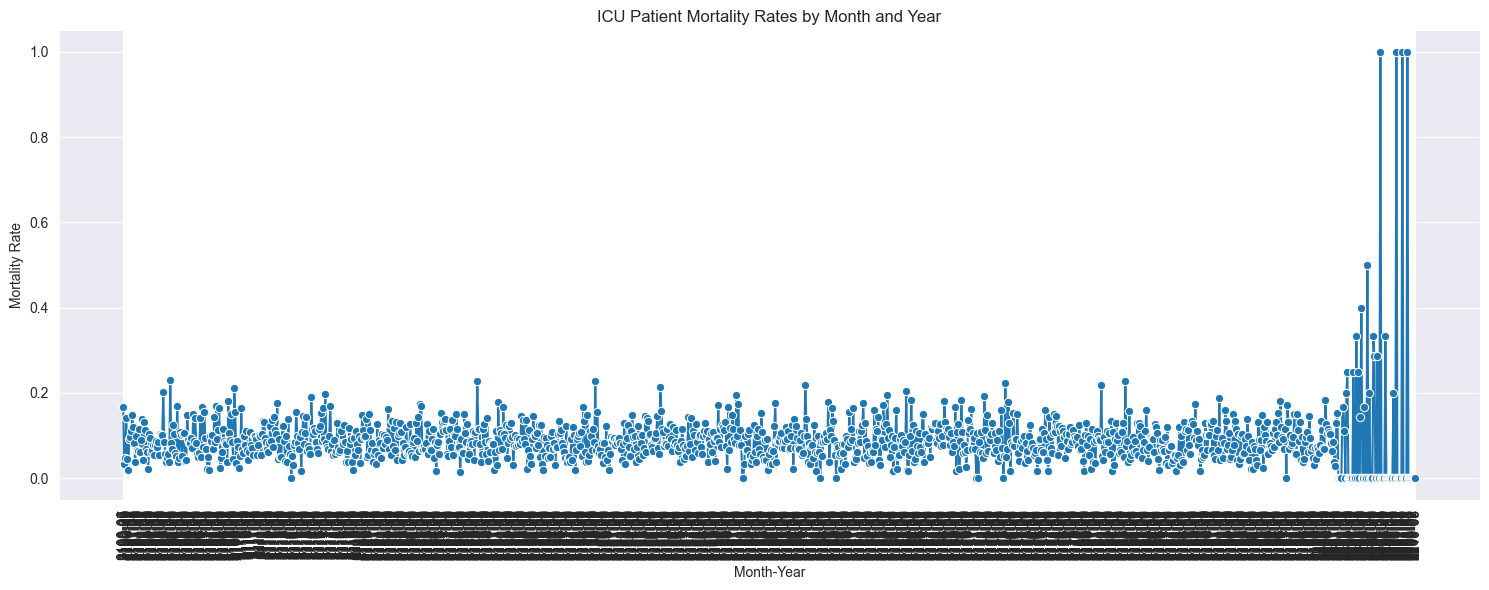

In [5]:
# Assuming patients_df, icustays_df, and admissions_df have been loaded correctly...

# Merge DataFrames to create final_df
merged_df = pd.merge(patients_df, icustays_df, on="SUBJECT_ID")
final_df = pd.merge(merged_df, admissions_df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'HOSPITAL_EXPIRE_FLAG']], on=["SUBJECT_ID", "HADM_ID"])

# Convert dates to datetime format
final_df['ADMITTIME'] = pd.to_datetime(final_df['ADMITTIME'])
final_df['INTIME'] = pd.to_datetime(final_df['INTIME'])
final_df['OUTTIME'] = pd.to_datetime(final_df['OUTTIME'])
final_df['DOD_HOSP'] = pd.to_datetime(final_df['DOD_HOSP'])
final_df['DOD'] = pd.to_datetime(final_df['DOD'])

# Create date range for each ICU stay
final_df['date_range'] = final_df.apply(lambda x: pd.date_range(start=x['INTIME'], end=x['OUTTIME']), axis=1)

# Explode date ranges into separate rows
dates_expanded = final_df.explode('date_range')

# Extract month and year from the date range
dates_expanded['month'] = dates_expanded['date_range'].dt.month
dates_expanded['year'] = dates_expanded['date_range'].dt.year

# Remove duplicates to ensure unique patient stays per month
unique_stays_per_month = dates_expanded.drop_duplicates(subset=['SUBJECT_ID', 'year', 'month'])

# Group by month and year and count unique patient stays
monthly_icu_stays = unique_stays_per_month.groupby(['year', 'month'])['SUBJECT_ID'].nunique().reset_index(name='total_icu_stays')

# Count deaths while ensuring each patient's death is only counted once per month
deaths_per_month = final_df[final_df['HOSPITAL_EXPIRE_FLAG'] == 1].copy()
deaths_per_month = deaths_per_month.drop_duplicates(subset=['SUBJECT_ID', 'DOD'])

# Group by DOD month and count unique deaths
deaths_per_month_grouped = deaths_per_month.groupby(deaths_per_month['DOD'].dt.to_period('M'))['SUBJECT_ID'].nunique().reset_index(name='deaths')
deaths_per_month_grouped['year'] = deaths_per_month_grouped['DOD'].dt.year
deaths_per_month_grouped['month'] = deaths_per_month_grouped['DOD'].dt.month

# Merge and calculate the mortality rate
monthly_mortality = pd.merge(monthly_icu_stays, deaths_per_month_grouped, on=['year', 'month'], how='left').fillna(0)
monthly_mortality['mortality_rate'] = monthly_mortality['deaths'] / monthly_mortality['total_icu_stays']

monthly_mortality['period'] = monthly_mortality['year'].astype(str) + '-' + monthly_mortality['month'].astype(str).str.zfill(2)

# Plot the mortality rate by month-year
plt.figure(figsize=(15, 6))
sns.lineplot(data=monthly_mortality, x='period', y='mortality_rate', marker='o')
plt.title('ICU Patient Mortality Rates by Month and Year')
plt.xlabel('Month-Year')
plt.ylabel('Mortality Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [6]:
final_df.columns

Index(['ROW_ID_x', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG', 'ROW_ID_y', 'HADM_ID', 'ICUSTAY_ID', 'DBSOURCE',
       'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
       'INTIME', 'OUTTIME', 'LOS', 'ADMITTIME', 'DISCHTIME',
       'HOSPITAL_EXPIRE_FLAG', 'date_range'],
      dtype='object')

In [7]:
monthly_mortality[monthly_mortality['mortality_rate'] <=1]

,year,month,total_icu_stays,DOD,deaths,mortality_rate,period
0,2100,6,6,2100-06,1.0,0.166667,2100-06
1,2100,7,29,2100-07,1.0,0.034483,2100-07
2,2100,8,43,2100-08,2.0,0.046512,2100-08
3,2100,9,57,2100-09,8.0,0.140351,2100-09
4,2100,10,45,2100-10,2.0,0.044444,2100-10
...,...,...,...,...,...,...,...
1288,2208,8,1,0,0.0,0.000000,2208-08
1289,2209,2,1,0,0.0,0.000000,2209-02
1290,2209,7,2,0,0.0,0.000000,2209-07
1291,2209,8,1,0,0.0,0.000000,2209-08


In [8]:
monthly_mortality[monthly_mortality['mortality_rate'] > 1]

,year,month,total_icu_stays,DOD,deaths,mortality_rate,period


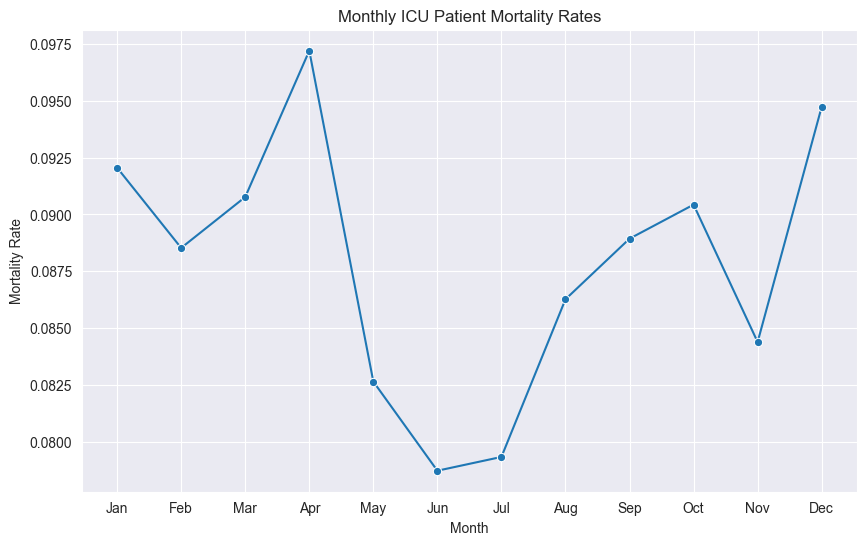

In [9]:
# For the month graph, we can group by the 'month' column alone and plot similarly
monthly_mortality_month_only = monthly_mortality.groupby('month').agg(
    total_deaths=('deaths', 'sum'),
    total_icu_stays=('total_icu_stays', 'sum')
).reset_index()
monthly_mortality_month_only['mortality_rate'] = monthly_mortality_month_only['total_deaths'] / monthly_mortality_month_only['total_icu_stays']

# Plot the mortality rate by month
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_mortality_month_only, x='month', y='mortality_rate', marker='o')
plt.title('Monthly ICU Patient Mortality Rates')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

In [10]:
# Calculate the monthly mortality rate, including min, max, and average for each month
monthly_mortality_stats = monthly_mortality.groupby('month').agg(
    min_mortality_rate=('mortality_rate', 'min'),
    max_mortality_rate=('mortality_rate', 'max'),
    avg_mortality_rate=('mortality_rate', 'mean')
).reset_index()

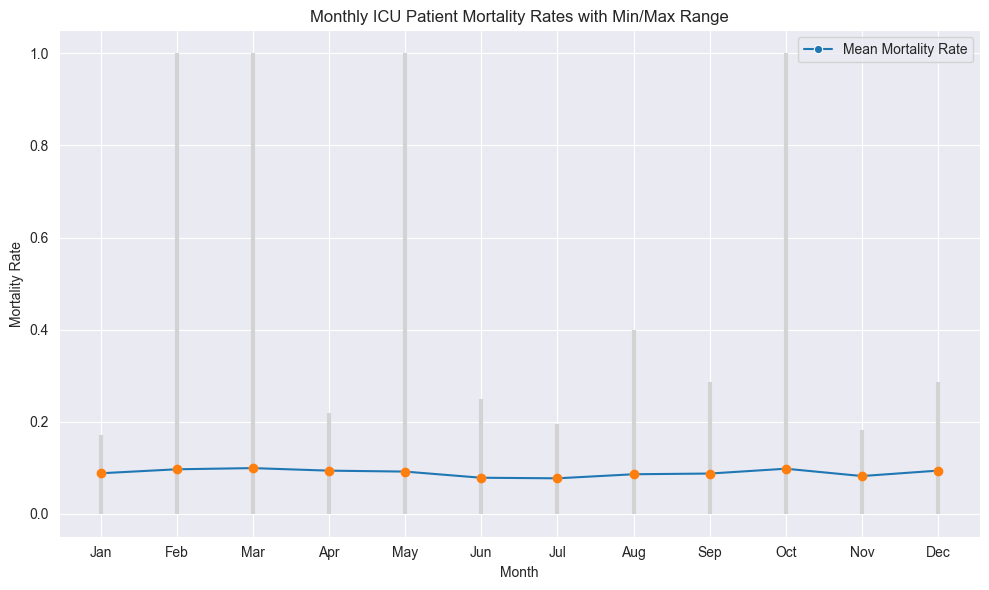

In [11]:
# First, we need to calculate the mean, min, and max mortality rates for each month
monthly_mortality_rates = monthly_mortality.groupby('month')['mortality_rate'].agg(['mean', 'min', 'max']).reset_index()

# Now, we'll plot the mean mortality rate and use the min and max values to show the variability as an error bar
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_mortality_rates, x='month', y='mean', marker='o', label='Mean Mortality Rate')

# Add error bars
plt.errorbar(monthly_mortality_rates['month'], monthly_mortality_rates['mean'],
             yerr=[monthly_mortality_rates['mean'] - monthly_mortality_rates['min'],
                   monthly_mortality_rates['max'] - monthly_mortality_rates['mean']],
             fmt='o', ecolor='lightgray', elinewidth=3, capsize=0)

plt.title('Monthly ICU Patient Mortality Rates with Min/Max Range')
plt.xlabel('Month')
plt.ylabel('Mortality Rate')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
monthly_mortality.head()

,year,month,total_icu_stays,DOD,deaths,mortality_rate,period
0,2100,6,6,2100-06,1.0,0.166667,2100-06
1,2100,7,29,2100-07,1.0,0.034483,2100-07
2,2100,8,43,2100-08,2.0,0.046512,2100-08
3,2100,9,57,2100-09,8.0,0.140351,2100-09
4,2100,10,45,2100-10,2.0,0.044444,2100-10


In [13]:
# monthly_mortality = monthly_mortality.sort_values(by=['year', 'month'])
# 
# plt.figure(figsize=(15, 7))
# for year in monthly_mortality['year'].unique():
#     subset = monthly_mortality[monthly_mortality['year'] == year]
#     plt.plot(subset['month'], subset['mortality_rate'], marker='o', label=year)
# 
# plt.title('Monthly ICU Patient Mortality Rates (Adjusted for ICU Stays per Month)')
# plt.xlabel('Month')
# plt.ylabel('Mortality Rate')
# plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# plt.legend(title='Year')
# plt.grid(True)
# plt.show()


# STL

The STL (Seasonal and Trend decomposition using Loess) graph shows the decomposition of the time series data into three components: seasonal, trend, and residual.

Seasonal: This panel shows the repeating pattern within the data that occurs at regular intervals - in your case, across months. Peaks and troughs in this plot suggest particular months when mortality rates are consistently higher or lower than the average.

Trend: This line represents the long-term progression of the data, ignoring seasonal fluctuations and irregular factors. An upward trend might indicate an increasing rate of mortality over time, while a downward trend would indicate a decrease.

Residual: These are the irregularities that are not captured by the seasonal or trend components. If these are random and show no pattern, it suggests that the seasonal and trend components have explained most of the time series behavior.

In [19]:
monthly_mortality.columns

Index(['year', 'month', 'total_icu_stays', 'DOD', 'deaths', 'mortality_rate',
       'period'],
      dtype='object')

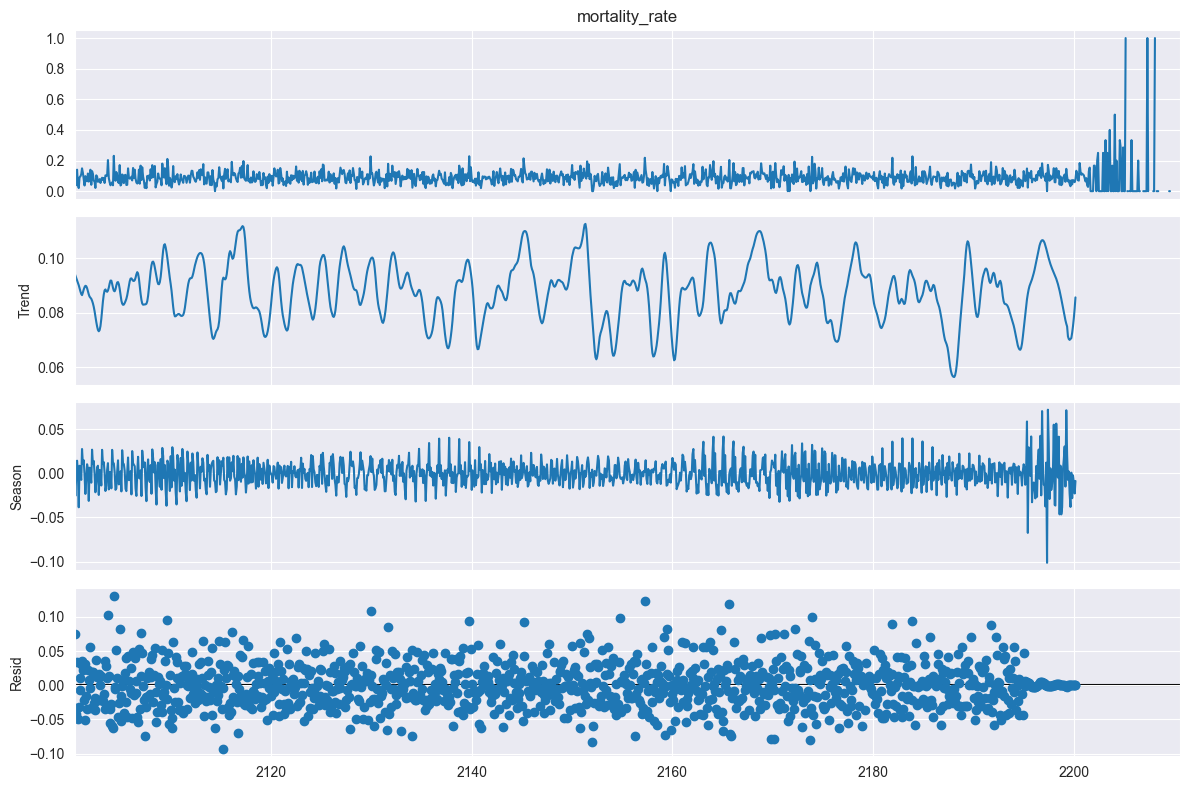

In [18]:
from statsmodels.tsa.seasonal import STL

# Have proper time series index
monthly_mortality['date'] = pd.to_datetime(monthly_mortality[['year', 'month']].assign(DAY=1))
monthly_mortality.set_index('date', inplace=True)
monthly_mortality.sort_index(inplace=True)

# Ensure the time series is complete with no missing months
monthly_mortality = monthly_mortality.asfreq('MS')

# If you have missing data after using asfreq, you might need to fill or interpolate the missing values
# For example, to forward-fill missing data:
# monthly_mortality['mortality_rate'] = monthly_mortality['mortality_rate'].fillna(method='ffill')

# Now the STL function should be able to infer the frequency
time_series = monthly_mortality['mortality_rate']

# Apply STL decomposition
stl = STL(time_series, seasonal=13)
result = stl.fit()

# Plot the STL decomposition results
result.plot()
plt.show()